## Phase 0: Le Sandbox Poétique



### Chargement du modèle


In [18]:
import sys
from pathlib import Path
from llama_cpp import Llama

# Chemin vers le modèle téléchargé
MODEL_PATH = "./models/Llama-3.2-1B-Instruct.Q4_K_M.gguf"

# Vérifier que le modèle existe
if not Path(MODEL_PATH).exists():
    print(f"erreur: Le modèle n'a pas été trouvé à {MODEL_PATH}")
    print("run python download_model.py")
    sys.exit(1)


# n_ctx=2048 signifie que le modèle peut se souvenir d'environ 1500 mots de conversation
llm = Llama(
    model_path=MODEL_PATH,
    n_ctx=2048,
    verbose=False  # True : voir les statistiques de vitesse
)

print("done")


llama_context: n_ctx_per_seq (2048) < n_ctx_train (131072) -- the full capacity of the model will not be utilized


done


### Sandbox

In [9]:
TOPIC = "le silence de l'hiver"
FORM = "sonnet"  # "sonnet", "limerick", "poème en vers libres"

prompt_structure = [
    {"role": "system", "content": "You are a skilled poet."},
    {"role": "user", "content": f"Write a {FORM} about {TOPIC} in french."}
]

print(f"\n--- Génération d'un {FORM} sur '{TOPIC}' ---\n")

output = llm.create_chat_completion(
    messages=prompt_structure,
    max_tokens=1000,   
    temperature=0.8,
    top_p=0.95,
)

poem = output["choices"][0]["message"]["content"]

print(poem)



--- Génération d'un sonnet sur 'le silence de l'hiver' ---

In le silence de l'hiver, les branches sont froisses,
Les feuilles se sont éteintes, comme des larmes,
Les arbres, qui ont chanté tout l'an,
Se courent, comme des souvenirs qui s'entretiennent.

Le vent souffle, un murmure doux et larme,
Les glaçons qui tombent de l'atmosphère,
Un mélange de glace et de mouchoir de larme,
Qui fait trembler les arbres, comme des éclairs de l'air.

Mais dans cette fin de hiver, je trouve un charme,
Un silence profond, qui me fait se lancer,
Vers les souvenirs, vers les souvenirs de la garde,
Vers les bois qui font chouer, les bois qui font chanter.

Et puis, dans ce silence, je trouve une paix,
Une paix qui me fait oublier mes souvenirs, ma grâce.

(Note: I've tried to follow the traditional sonnet structure and rhyme scheme, but I want to acknowledge that "le silence de l'hiver" is a bit of a challenging topic for a sonnet, as it's more of a poetic description than a traditional narrative. If 

## Sauvegarder le poème 


In [3]:
from pathlib import Path
from datetime import datetime

output_file = Path("poem.txt")
output_file.write_text(poem, encoding="utf-8")



544

### Implémentation du graphe thématique et de la fonction graph_to_prompt


In [6]:
def graph_to_prompt(graph, form_spec):
    """
    Transforme un graphe thématique en prompt structuré pour la génération poétique.
    
    Args:
        graph: dict avec "nodes" (list) et "edges" (list de tuples)
        form_spec: dict avec "form" (str) et "total_lines" (int)
    
    Returns:
        str: prompt structuré détaillant le plan de chaque section
    """
    nodes = graph["nodes"]
    edges = graph["edges"]
    form = form_spec["form"]
    total_lines = form_spec["total_lines"]
    
    # Calculer la distribution des lignes
    num_sections = len(nodes) + len(edges) + 1  # sections pour chaque noeud, chaque transition, + synthèse
    lines_per_section = total_lines // num_sections
    remainder = total_lines % num_sections
    
    prompt_parts = [
        f"You will write a {total_lines}-line {form} in French.",
        "Follow this structured plan for each section:",
        ""
    ]
    
    line_num = 1
    
    # Section pour chaque noeud initial
    for i, node in enumerate(nodes):
        end_line = line_num + lines_per_section - 1
        if i < remainder:
            end_line += 1
        prompt_parts.append(f"Lines {line_num}-{end_line}: Focus on '{node}' imagery and emotions.")
        line_num = end_line + 1
    
    # Sections pour les transitions (edges)
    for i, (source, target) in enumerate(edges):
        end_line = line_num + lines_per_section - 1
        if len(nodes) + i < remainder:
            end_line += 1
        prompt_parts.append(f"Lines {line_num}-{end_line}: Transition from '{source}' to '{target}'.")
        line_num = end_line + 1
    
    # Section de synthèse finale
    if line_num <= total_lines:
        remaining_lines = total_lines - line_num + 1
        all_nodes = ", ".join(nodes)
        prompt_parts.append(f"Lines {line_num}-{total_lines}: Synthesize all themes ({all_nodes}) in a concluding reflection.")
    
    return "\n".join(prompt_parts)

# Exemple de graphe thématique
example_graph = {
    "nodes": ["deuil", "mémoire", "océan"],
    "edges": [("deuil", "mémoire"), ("mémoire", "océan")]
}

# Spécification pour un sonnet (14 lignes)
sonnet_spec = {
    "form": "sonnet",
    "total_lines": 14
}

# Générer le prompt structuré
structured_prompt = graph_to_prompt(example_graph, sonnet_spec)
print("=== Prompt structuré généré ===\n")
print(structured_prompt)


=== Prompt structuré généré ===

You will write a 14-line sonnet in French.
Follow this structured plan for each section:

Lines 1-3: Focus on 'deuil' imagery and emotions.
Lines 4-6: Focus on 'mémoire' imagery and emotions.
Lines 7-8: Focus on 'océan' imagery and emotions.
Lines 9-10: Transition from 'deuil' to 'mémoire'.
Lines 11-12: Transition from 'mémoire' to 'océan'.
Lines 13-14: Synthesize all themes (deuil, mémoire, océan) in a concluding reflection.


### Génération avec le graphe thématique


In [ ]:

TOPIC_GRAPH = {
    "nodes": ["deuil", "mémoire", "océan"],
    "edges": [("deuil", "mémoire"), ("mémoire", "océan")]
}

FORM_SPEC = {
    "form": "sonnet",
    "total_lines": 14
}


structured_instructions = graph_to_prompt(TOPIC_GRAPH, FORM_SPEC)

prompt_with_graph = [
    {"role": "system", "content": "You are a skilled poet. Write in French."},
    {"role": "user", "content": structured_instructions}
]

print("=== Génération avec graphe thématique ===\n")
print("Instructions structurées:")
print(structured_instructions)
print("\n" + "="*50 + "\n")

output_graph = llm.create_chat_completion(
    messages=prompt_with_graph,
    max_tokens=1000,
    temperature=0.8,
    top_p=0.95,
)

poem_with_graph = output_graph["choices"][0]["message"]["content"]
print(poem_with_graph)


=== Génération avec graphe thématique ===

Instructions structurées:
You will write a 14-line sonnet in French.
Follow this structured plan for each section:

Lines 1-3: Focus on 'deuil' imagery and emotions.
Lines 4-6: Focus on 'mémoire' imagery and emotions.
Lines 7-8: Focus on 'océan' imagery and emotions.
Lines 9-10: Transition from 'deuil' to 'mémoire'.
Lines 11-12: Transition from 'mémoire' to 'océan'.
Lines 13-14: Synthesize all themes (deuil, mémoire, océan) in a concluding reflection.


Dans l'ombre sombre où deuil éclate
Les souvenirs se répandent comme des feuilles
Froides et éphémères qui brûlent dans la mémoire
Comme des rêves qui disparaissent dans l'océan

Les ténèbres me recueillent comme des oiseaux
Qui retournent vers leurs ailes mortes, sans voix
Les étoiles éclatent dans l'espace sombre comme des éclairs
Comme des larmes qui ne peuvent plus pleurer dans l'océan

Le temps me frappe comme un tonnerre
Qui me fait trembler sous le poids de mes souvenirs
Les vagues de la

## Phase 2: Préparation des données


In [19]:
from pathlib import Path
from src.prepare_data import download_french_poetry, process_corpus

raw_dir = Path("./data/raw")
processed_dir = Path("./data/processed")
raw_dir.mkdir(parents=True, exist_ok=True)
processed_dir.mkdir(parents=True, exist_ok=True)

raw_file = raw_dir / "french_poetry.json"
processed_file = processed_dir / "french_poetry_processed.json"

if not raw_file.exists():
    print("Téléchargement du corpus depuis HuggingFace...")
    raw_data = download_french_poetry()
    
    import json
    with open(raw_file, "w", encoding="utf-8") as f:
        json.dump(raw_data, f, ensure_ascii=False, indent=2)
    print(f"{len(raw_data)} poèmes téléchargés")
else:
    print("Corpus brut déjà présent")
    import json
    with open(raw_file, "r", encoding="utf-8") as f:
        raw_data = json.load(f)

if not processed_file.exists():
    print("\nTraitement du corpus...")
    poems = process_corpus(raw_data, processed_file)
    print(f"{len(poems)} poèmes traités et sauvegardés")
else:
    print("Corpus traité déjà présent")
    import json
    with open(processed_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        poems = data.get("poems", [])


Téléchargement du corpus depuis HuggingFace...
1821 poèmes téléchargés

Traitement du corpus...
1818 poèmes traités et sauvegardés



Nombre total de poèmes: 1818

Statistiques des mots:
  Moyenne: 264.4
  Médiane: 154.0
  Min: 20
  Max: 3148

Statistiques des lignes:
  Moyenne: 37.3
  Médiane: 24.0
  Min: 4
  Max: 373

Statistiques des caractères:
  Moyenne: 1474.1
  Médiane: 859.5
  Min: 115
  Max: 17301


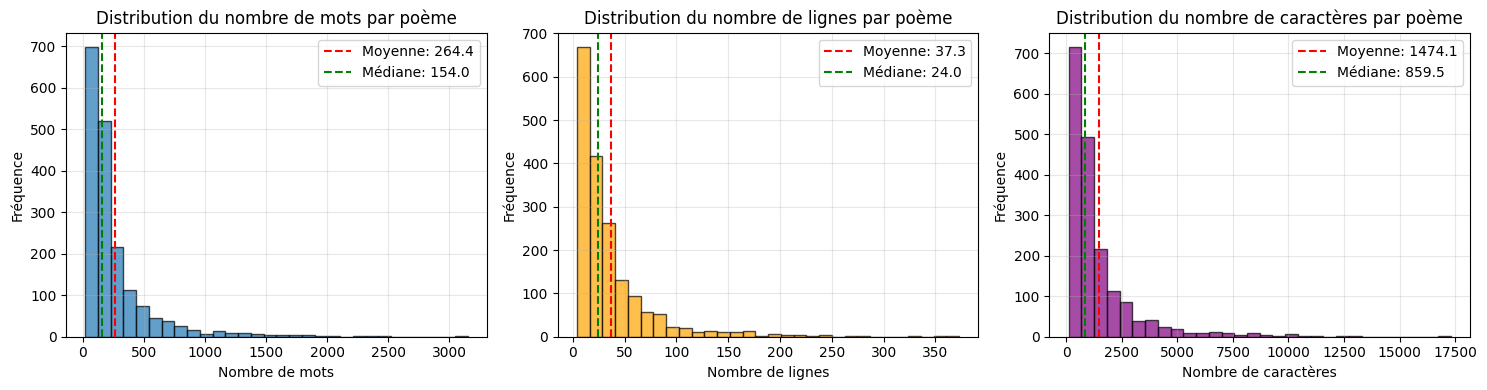

In [21]:
from src.prepare_data import analyze_corpus, plot_distributions

stats = analyze_corpus(poems)

print(f"\nNombre total de poèmes: {stats['total_poems']}")

print("\nStatistiques des mots:")
print(f"  Moyenne: {stats['word_stats']['mean']:.1f}")
print(f"  Médiane: {stats['word_stats']['median']:.1f}")
print(f"  Min: {stats['word_stats']['min']}")
print(f"  Max: {stats['word_stats']['max']}")

print("\nStatistiques des lignes:")
print(f"  Moyenne: {stats['line_stats']['mean']:.1f}")
print(f"  Médiane: {stats['line_stats']['median']:.1f}")
print(f"  Min: {stats['line_stats']['min']}")
print(f"  Max: {stats['line_stats']['max']}")

print("\nStatistiques des caractères:")
print(f"  Moyenne: {stats['char_stats']['mean']:.1f}")
print(f"  Médiane: {stats['char_stats']['median']:.1f}")
print(f"  Min: {stats['char_stats']['min']}")
print(f"  Max: {stats['char_stats']['max']}")

plot_distributions(stats)


### Fine-tuning du modèle


In [24]:
from src.finetuning import finetune_model
from pathlib import Path

corpus_file = Path("./data/processed/french_poetry_processed.json")
output_dir = Path("./models/finetuned")

print("Démarrage du fine-tuning...")
print("(Cela peut prendre plusieurs minutes)")

try:
    model_path = finetune_model(
        corpus_path=str(corpus_file),
        output_dir=str(output_dir),
        max_steps=300
    )
    print(f"\nFine-tuning terminé!")
    print(f"Modèle sauvegardé dans: {model_path}")
except Exception as e:
    print(f"Erreur lors du fine-tuning: {e}")
    raise


Démarrage du fine-tuning...
(Cela peut prendre plusieurs minutes)
==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 5080 Laptop GPU. Num GPUs = 1. Max memory: 15.92 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Map:   0%|          | 0/1818 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=12):   0%|          | 0/1818 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,818 | Num Epochs = 2 | Total steps = 300
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 11,272,192 of 1,247,086,592 (0.90% trained)


Step,Training Loss
1,3.729200
2,3.834800
3,3.896000
4,3.720200
5,3.534000
6,3.683200
7,3.384800
8,3.382200
9,3.402300
10,3.307600



Fine-tuning terminé!
Modèle sauvegardé dans: models/finetuned


### Visualisation de l'entraînement


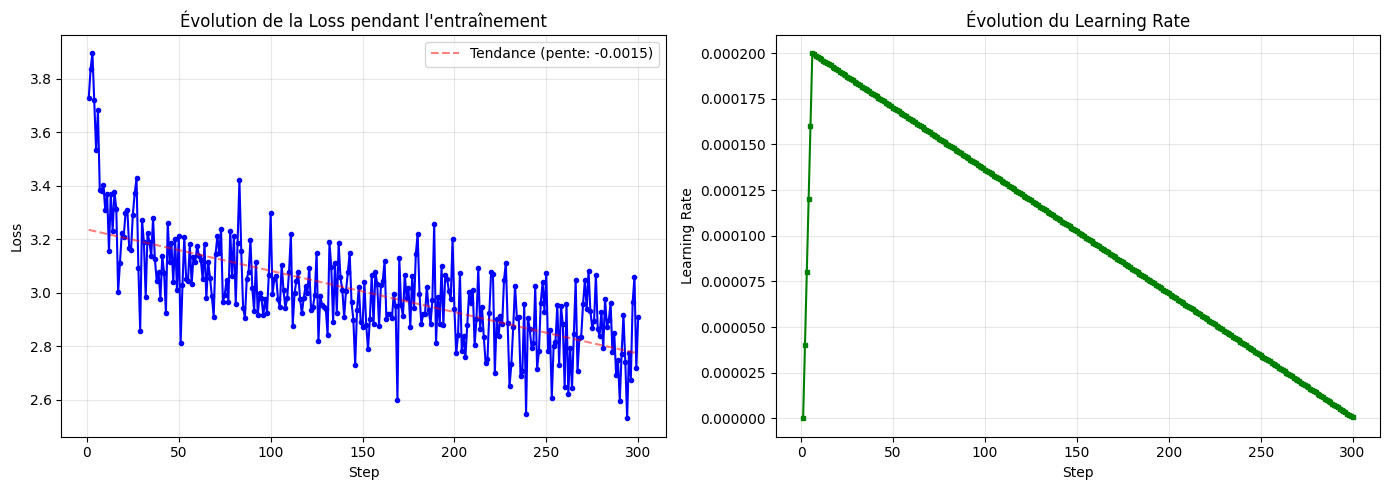

In [25]:
from src.finetuning import plot_training_loss

try:
    plot_training_loss()
except FileNotFoundError as e:
    print(f"Fichier d'historique non trouvé: {e}")
    print("Assurez-vous d'avoir exécuté le fine-tuning d'abord.")
except Exception as e:
    print(f"Erreur lors de la visualisation: {e}")


## Phase 3 : Comparaison des Approches

Cette section compare 4 approches pour déterminer si le scaffolding structurel est suffisant seul ou agit comme multiplicateur avec la spécialisation des poids :

1. **Baseline** : Modèle générique + prompt simple
2. **Structure only** : Modèle générique + graphe thématique
3. **Specialization only** : Modèle fine-tuné + prompt simple
4. **Structure + Specialization** : Modèle fine-tuné + graphe thématique

### Configuration


In [33]:
from src.comparison import run_comparison, visualize_comparison
from pathlib import Path
from datetime import datetime
import json

TOPIC_GRAPH = {
    "nodes": ["deuil", "mémoire", "océan"],
    "edges": [("deuil", "mémoire"), ("mémoire", "océan")]
}

FORM_SPEC = {
    "form": "sonnet",
    "total_lines": 14
}

GENERATION_PARAMS = {
    "max_tokens": 1000,
    "temperature": 0.8,
    "top_p": 0.95
}


In [34]:
results = run_comparison(
    llm=llm,
    topic_graph=TOPIC_GRAPH,
    form_spec=FORM_SPEC,
    generation_params=GENERATION_PARAMS
)

print("Comparaison terminée!")
for approach_name, data in results.items():
    print(f"- {data['description']}: {data['metrics']['word_count']} mots")


==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 5080 Laptop GPU. Num GPUs = 1. Max memory: 15.92 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Comparaison terminée!
- Modèle générique + prompt simple: 157 mots
- Modèle générique + graphe thématique: 169 mots
- Modèle fine-tuné + prompt simple: 144 mots
- Modèle fine-tuné + graphe thématique: 112 mots


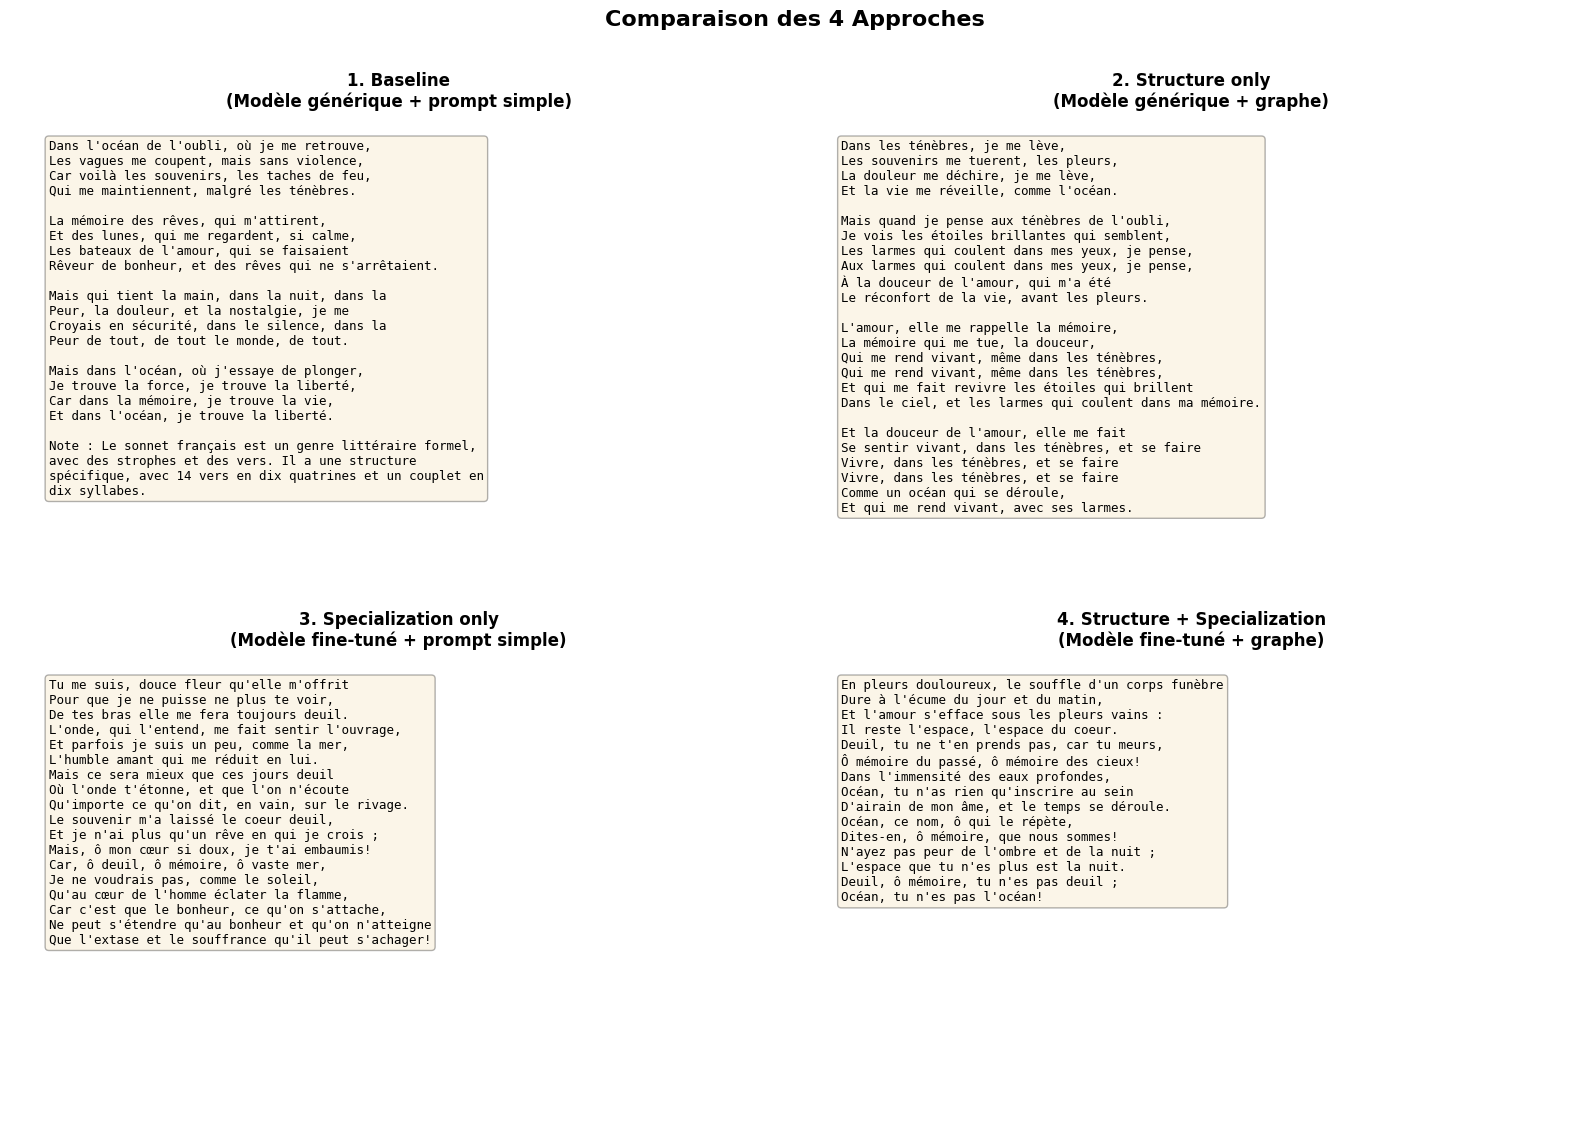

Tableau des métriques :
                  Approche  Mots  Lignes  Caractères  Vocabulaire unique  Longueur moyenne ligne
                  Baseline   157      17         868                  82               49.882353
            Structure only   169      22         910                  61               40.272727
       Specialization only   144      18         769                  93               41.777778
Structure + Specialization   112      15         594                  72               38.666667


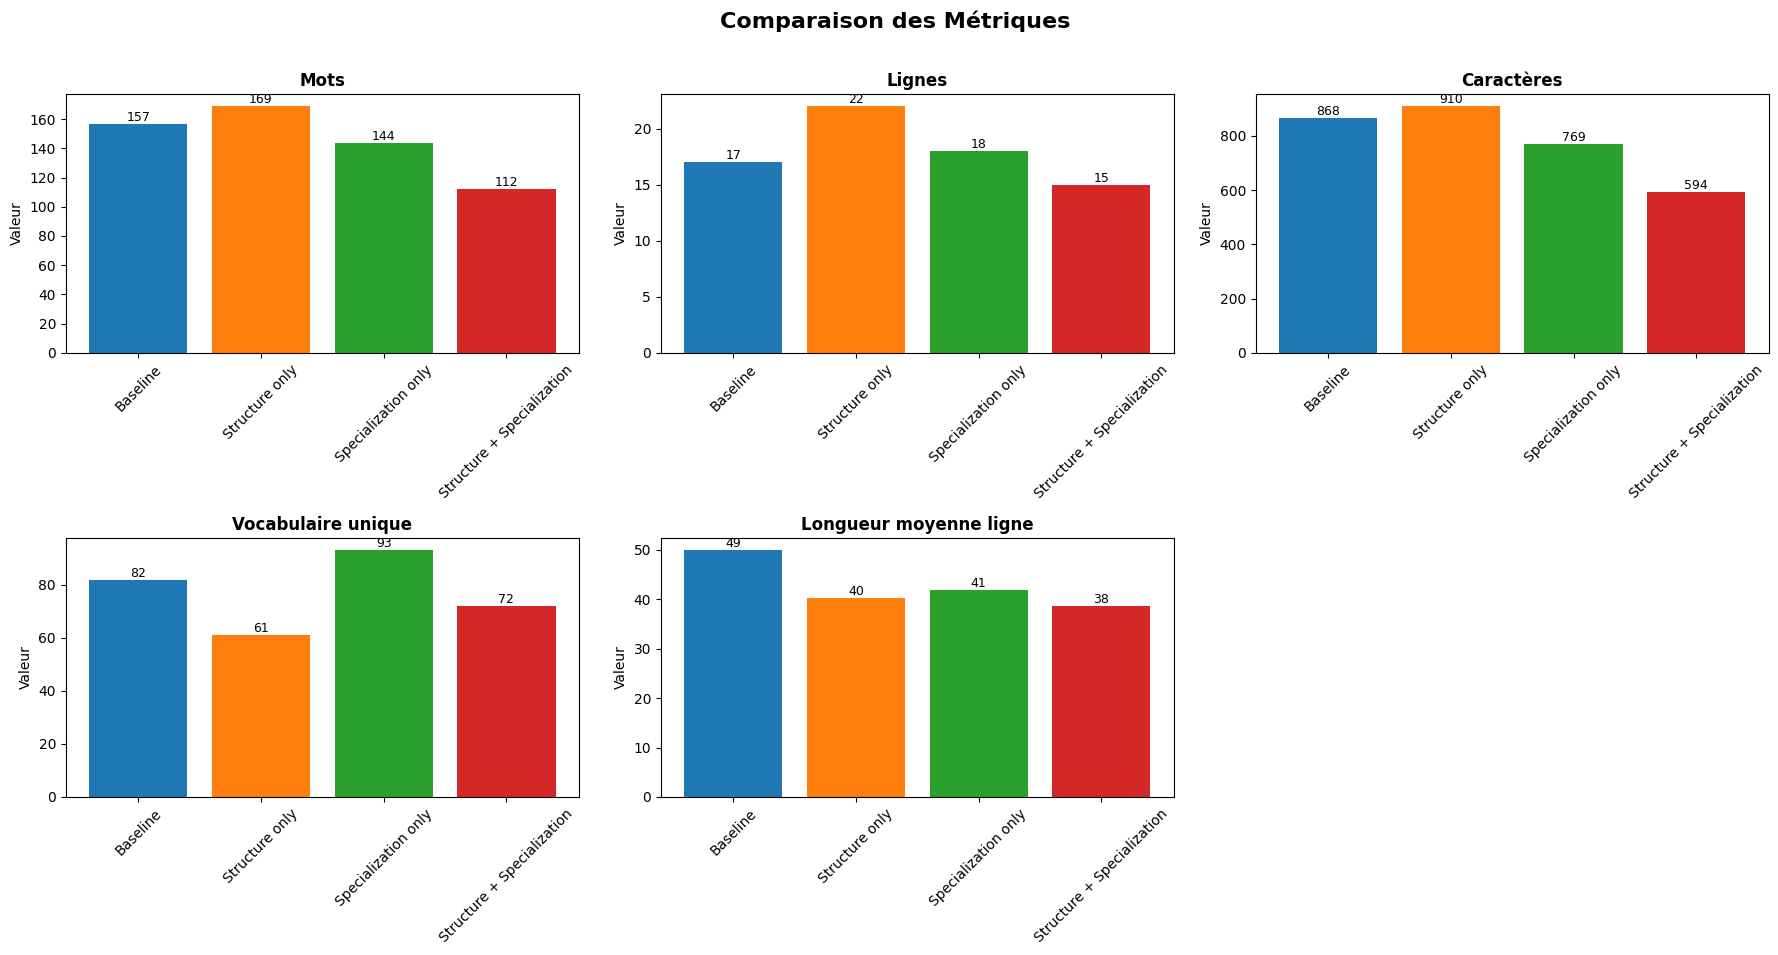

In [47]:
import importlib
import src.comparison.visualization
importlib.reload(src.comparison.visualization)
from src.comparison.visualization import visualize_comparison

visualize_comparison(results)


In [28]:
results_dir = Path("./results/comparison")
results_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = results_dir / f"comparison_{timestamp}.json"

results_data = {
    "timestamp": timestamp,
    "config": {
        "topic_graph": TOPIC_GRAPH,
        "form_spec": FORM_SPEC,
        "generation_params": GENERATION_PARAMS
    },
    "approaches": results
}

with open(results_file, "w", encoding="utf-8") as f:
    json.dump(results_data, f, ensure_ascii=False, indent=2)

print(f"Résultats sauvegardés dans: {results_file}")


Résultats sauvegardés dans: results/comparison/comparison_20251223_024634.json


## Phase 4 : Génération Itérative avec Feedback

Cette section implémente une boucle de critique où le modèle évalue sa propre génération et génère des versions révisées pour améliorer la cohérence et l'imagerie poétique.

Le processus :
1. **Génération initiale** : Poème généré (déjà fait en Phase 3)
2. **Critique** : Le modèle analyse son propre poème
3. **Révision** : Le modèle génère une version améliorée basée sur la critique
4. **Itération** : Répéter le processus pour affiner davantage


### Configuration


In [ ]:
from src.iterative import run_iterative_generation, visualize_iterative_results
from src.comparison.helpers import load_finetuned_model
from pathlib import Path
from datetime import datetime
import json

NUM_ITERATIONS = 2

finetuned_model, finetuned_tokenizer = load_finetuned_model()


==((====))==  Unsloth 2025.12.8: Fast Llama patching. Transformers: 4.57.3.
   \\   /|    NVIDIA GeForce RTX 5080 Laptop GPU. Num GPUs = 1. Max memory: 15.92 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 12.0. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


### Exécution itérative sur les 4 approches


In [49]:
iterative_results = {}

prompt_baseline = f"Écris un {FORM_SPEC['form']} en français sur les thèmes de {', '.join(TOPIC_GRAPH['nodes'])}."
from src.comparison.helpers import graph_to_prompt
structured_instructions = graph_to_prompt(TOPIC_GRAPH, FORM_SPEC)

print("Exécution de la génération itérative sur les 4 approches...\n")

iterative_results["baseline"] = run_iterative_generation(
    llm=llm,
    poem=results["baseline"]["poem"],
    prompt=prompt_baseline,
    form_spec=FORM_SPEC,
    generation_params=GENERATION_PARAMS,
    num_iterations=NUM_ITERATIONS,
    model_type="generic"
)
print("Baseline terminée")

iterative_results["structure_only"] = run_iterative_generation(
    llm=llm,
    poem=results["structure_only"]["poem"],
    prompt=structured_instructions,
    form_spec=FORM_SPEC,
    generation_params=GENERATION_PARAMS,
    num_iterations=NUM_ITERATIONS,
    model_type="generic"
)
print("Structure only terminée")

if finetuned_model is not None:
    iterative_results["specialization_only"] = run_iterative_generation(
        llm=llm,
        poem=results["specialization_only"]["poem"],
        prompt=prompt_baseline,
        form_spec=FORM_SPEC,
        generation_params=GENERATION_PARAMS,
        num_iterations=NUM_ITERATIONS,
        model_type="finetuned",
        finetuned_model=finetuned_model,
        finetuned_tokenizer=finetuned_tokenizer
    )
    print("Specialization only terminée")
    
    iterative_results["structure_specialization"] = run_iterative_generation(
        llm=llm,
        poem=results["structure_specialization"]["poem"],
        prompt=structured_instructions,
        form_spec=FORM_SPEC,
        generation_params=GENERATION_PARAMS,
        num_iterations=NUM_ITERATIONS,
        model_type="finetuned",
        finetuned_model=finetuned_model,
        finetuned_tokenizer=finetuned_tokenizer
    )
    print("Structure + Specialization terminée")
else:
    print("Modèle fine-tuné non disponible. Approches 3 et 4 identiques aux approches 1 et 2.")
    iterative_results["specialization_only"] = iterative_results["baseline"]
    iterative_results["structure_specialization"] = iterative_results["structure_only"]

print("\nGénération itérative terminée pour toutes les approches")


Exécution de la génération itérative sur les 4 approches...

Baseline terminée
Structure only terminée
Specialization only terminée
Structure + Specialization terminée

Génération itérative terminée pour toutes les approches


### Visualisation des résultats itératifs


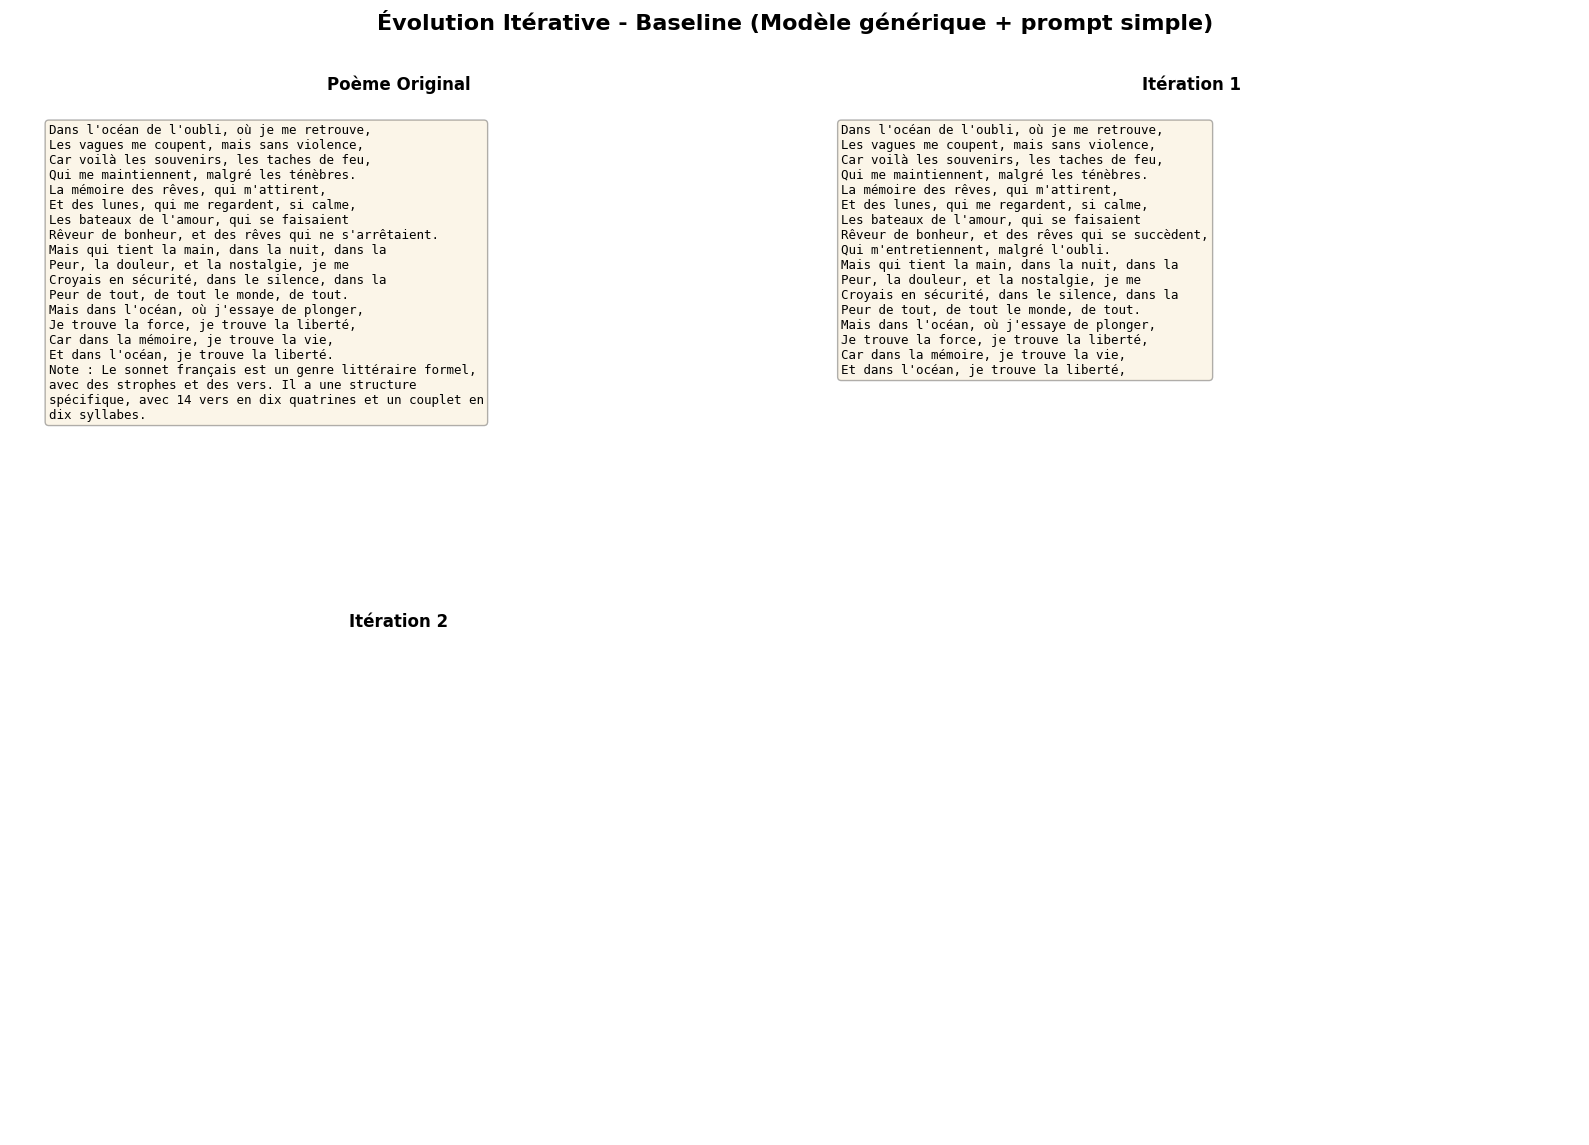


Évolution des métriques - Baseline (Modèle générique + prompt simple):
    Version  Mots  Lignes  Vocabulaire
   Original   157      17           82
Itération 1   559      45          190
Itération 2   214      21          124
Itération 3   546      31          212


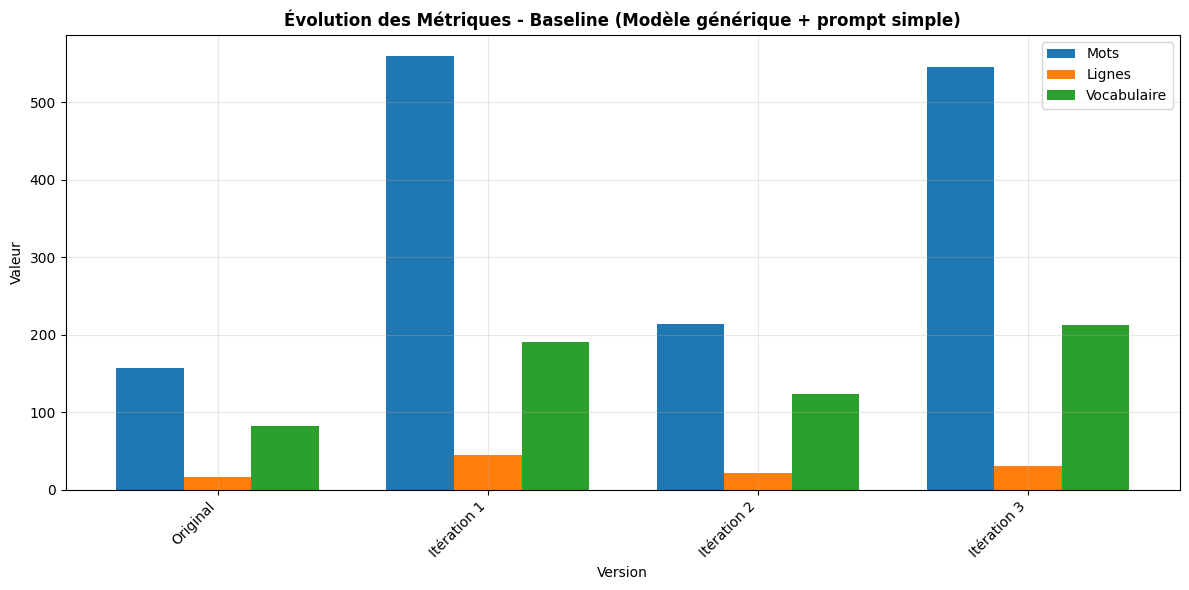

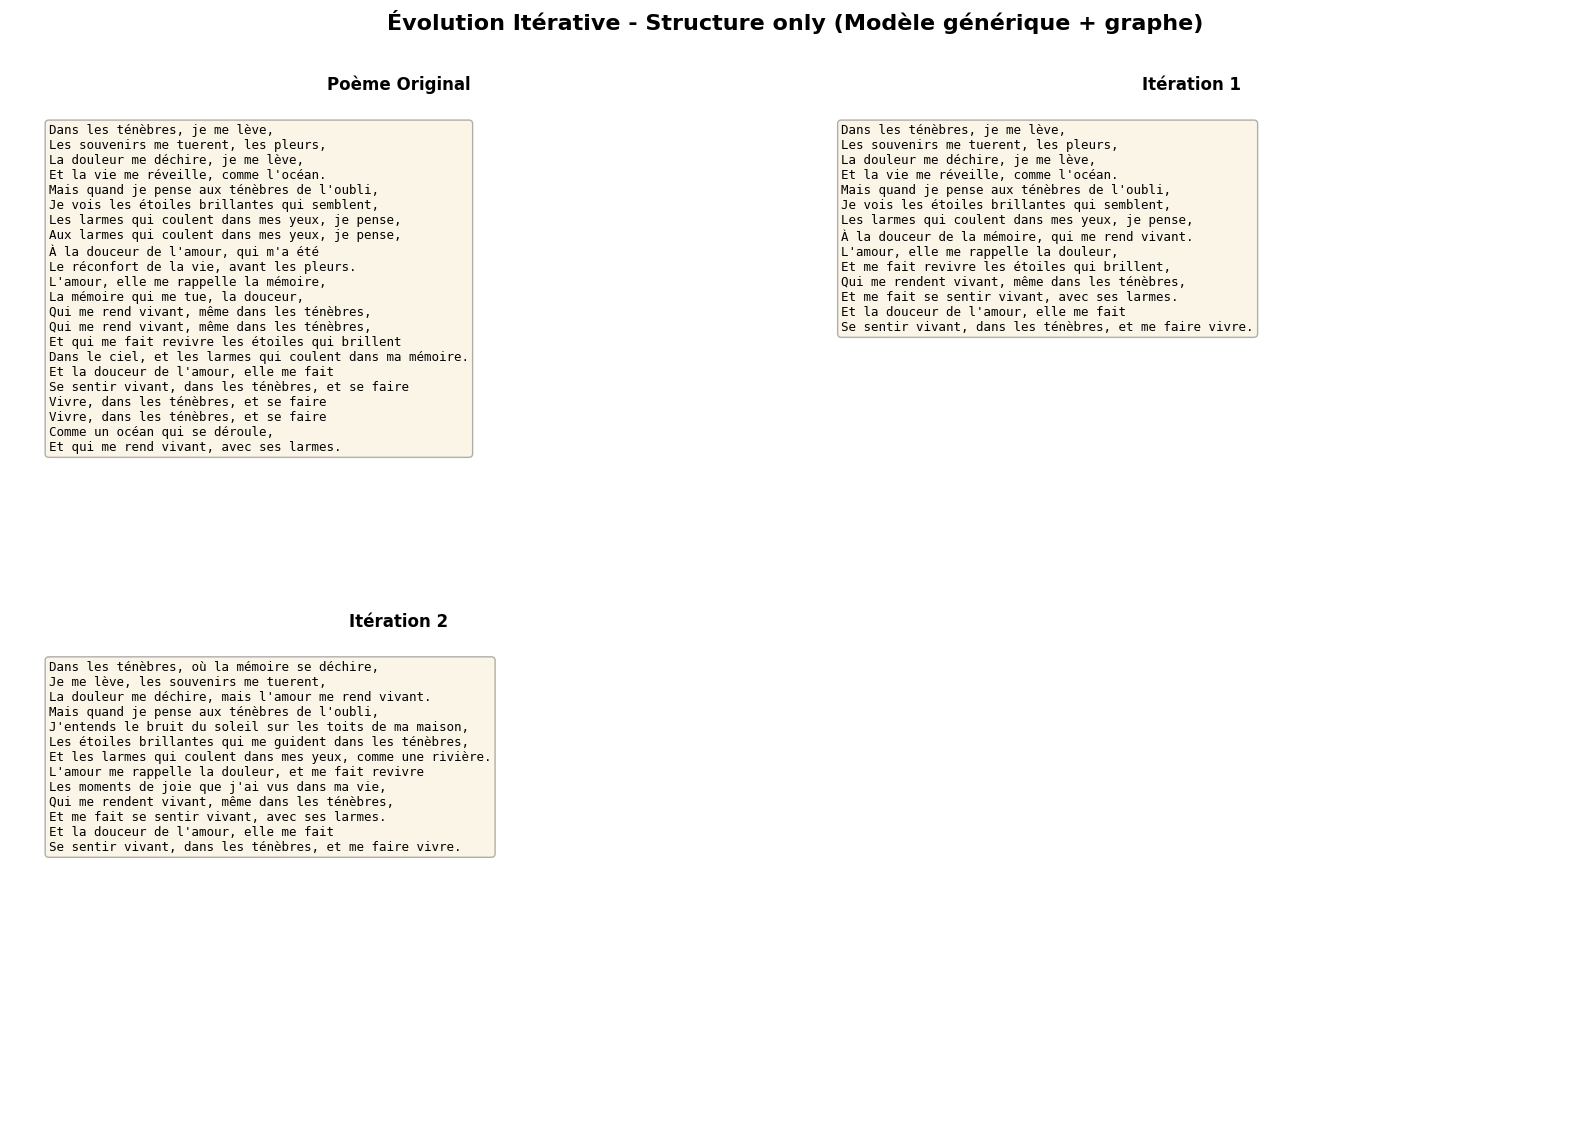


Évolution des métriques - Structure only (Modèle générique + graphe):
    Version  Mots  Lignes  Vocabulaire
   Original   169      22           61
Itération 1   584      38          207
Itération 2   222      19          107
Itération 3   537      39          163


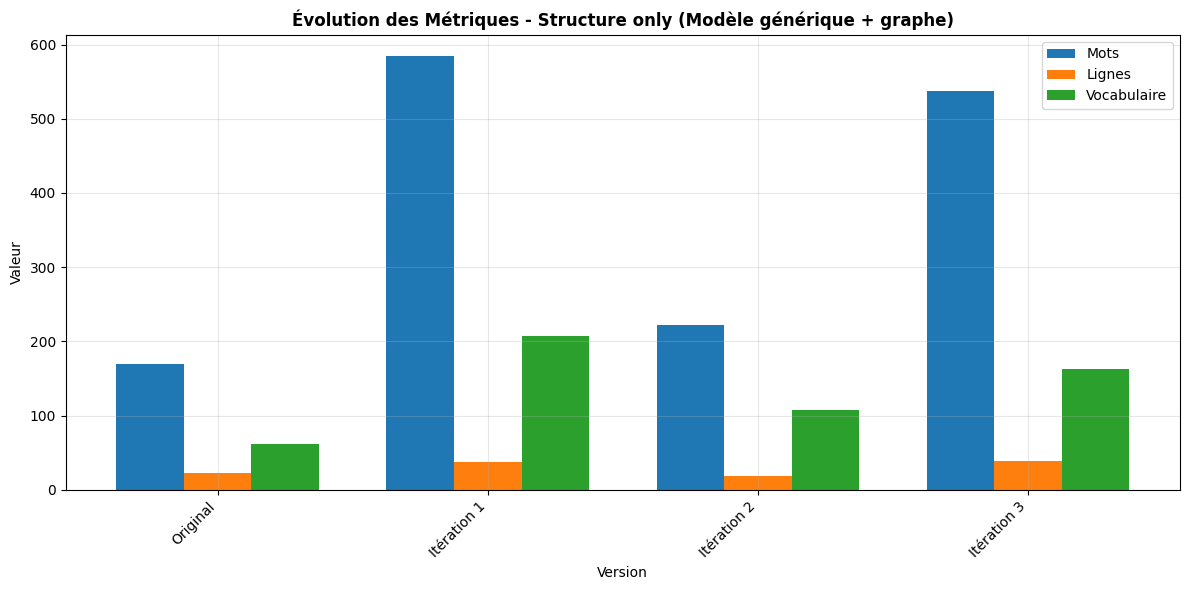

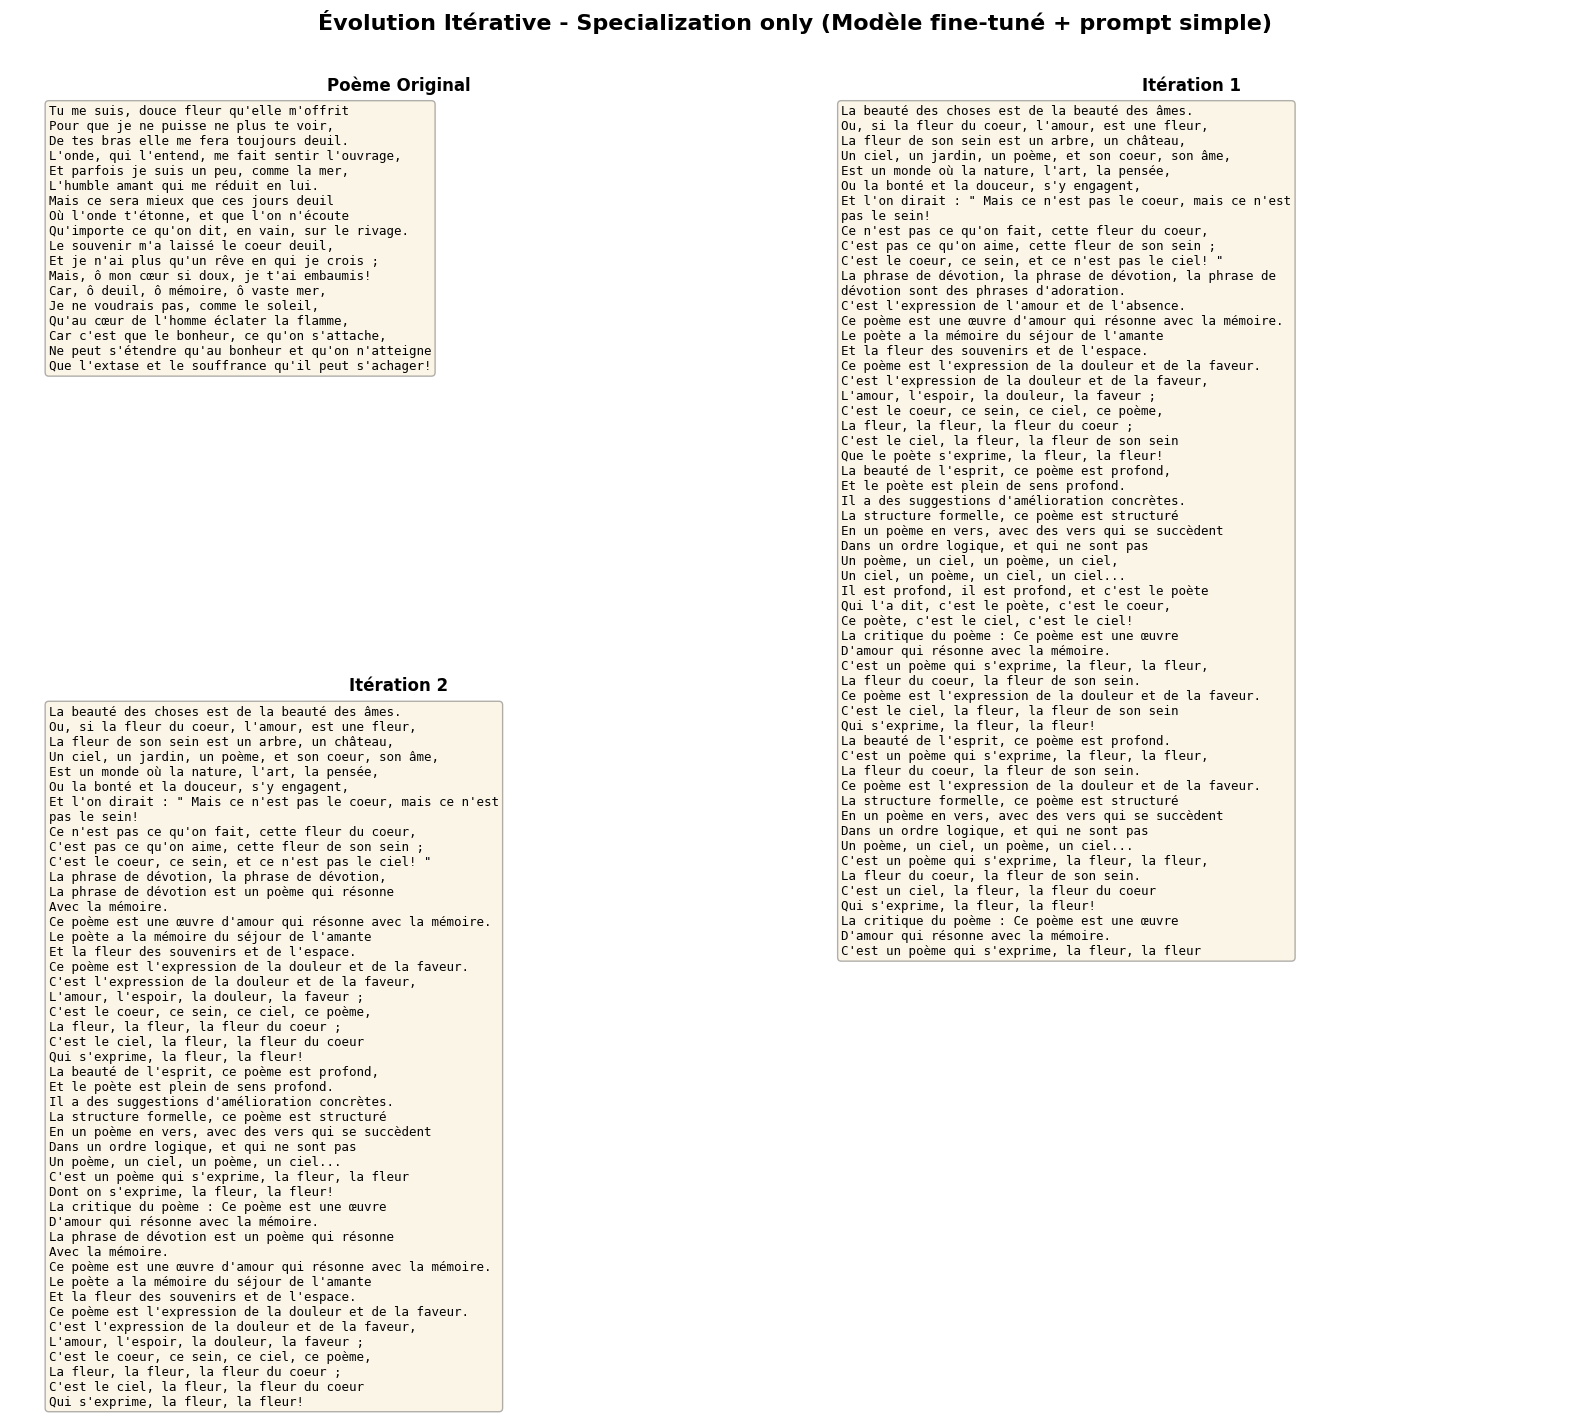


Évolution des métriques - Specialization only (Modèle fine-tuné + prompt simple):
    Version  Mots  Lignes  Vocabulaire
   Original   144      18           93
Itération 1   574      63          103
Itération 2   431      49           99
Itération 3    73       9           20


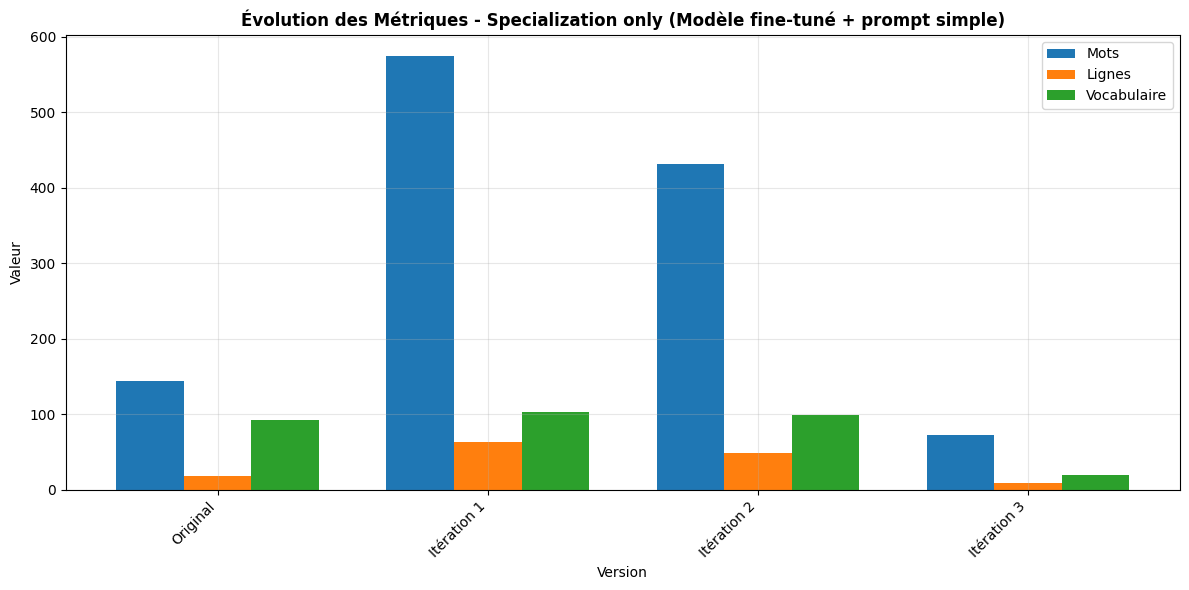

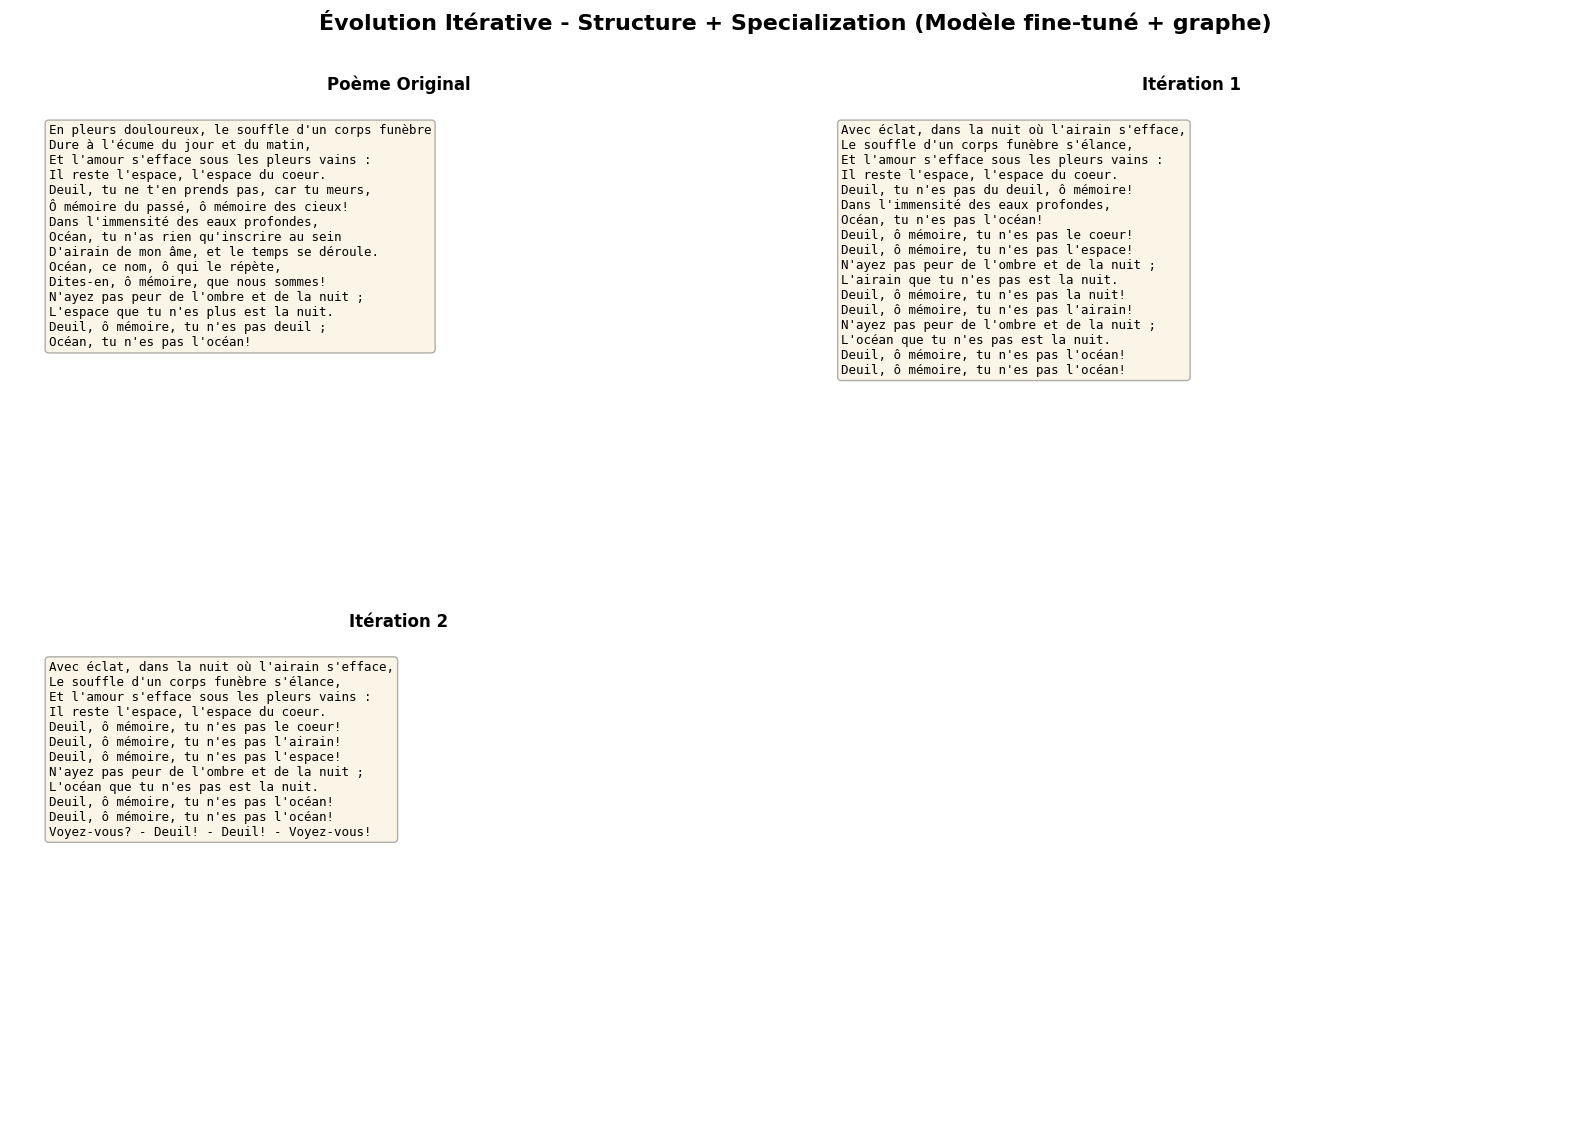


Évolution des métriques - Structure + Specialization (Modèle fine-tuné + graphe):
    Version  Mots  Lignes  Vocabulaire
   Original   112      15           72
Itération 1   163      22           64
Itération 2    89      12           41
Itération 3   215      13           93


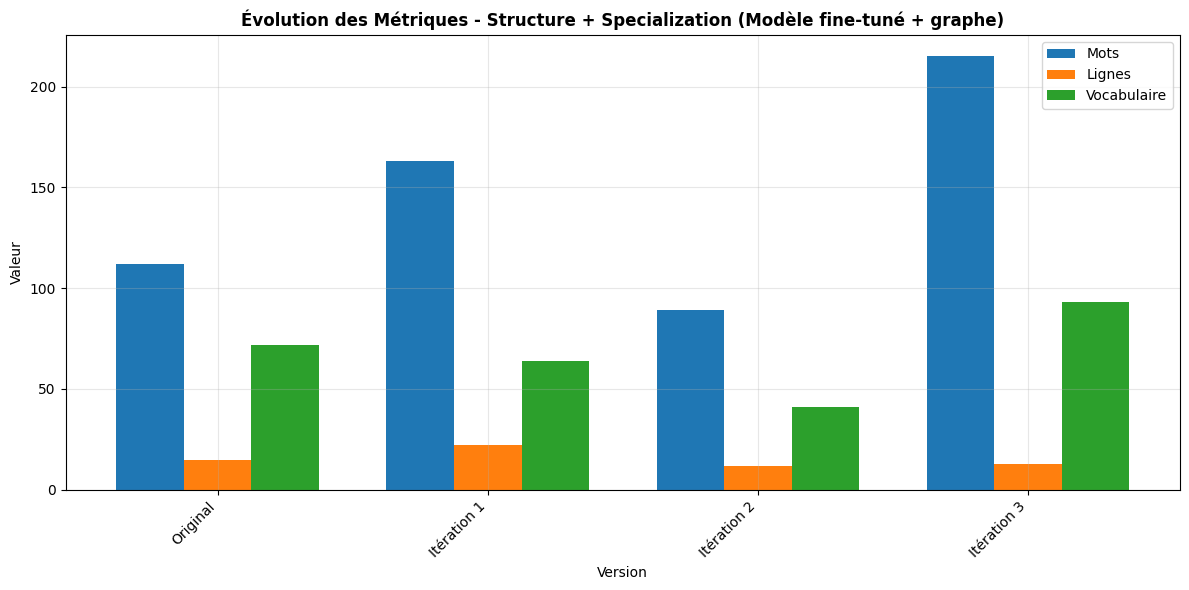

In [58]:


approach_names = {
    "baseline": "Baseline (Modèle générique + prompt simple)",
    "structure_only": "Structure only (Modèle générique + graphe)",
    "specialization_only": "Specialization only (Modèle fine-tuné + prompt simple)",
    "structure_specialization": "Structure + Specialization (Modèle fine-tuné + graphe)"
}

for key, name in approach_names.items():
    if key in iterative_results:
        visualize_iterative_results(iterative_results[key], name)


### Sauvegarde des résultats itératifs


In [53]:
results_dir = Path("./results/iterative")
results_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = results_dir / f"iterative_{timestamp}.json"

iterative_data = {
    "timestamp": timestamp,
    "config": {
        "topic_graph": TOPIC_GRAPH,
        "form_spec": FORM_SPEC,
        "generation_params": GENERATION_PARAMS,
        "num_iterations": NUM_ITERATIONS
    },
    "results": iterative_results
}

with open(results_file, "w", encoding="utf-8") as f:
    json.dump(iterative_data, f, ensure_ascii=False, indent=2)

print(f"Résultats itératifs sauvegardés dans: {results_file}")


Résultats itératifs sauvegardés dans: results/iterative/iterative_20251223_032858.json
